In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import os
from tqdm import tqdm
from PIL import Image

## Setting Up the Device

We first set up the device to use GPU if available; otherwise, we fall back to the CPU.

In [10]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Preparation

We define the transformations for the training, validation, and test datasets. These transformations include converting images to grayscale, resizing, and normalizing.

In [11]:
# Data preparation
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48, 48)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),  # Increased rotation
        transforms.RandomAffine(0, translate=(0.2, 0.2), scale=(0.8, 1.2)),  # Added scaling
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Added color jitter
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

## Loading and Splitting the Dataset

We load the datasets from the given directory and split the training dataset into training and validation sets.

In [12]:
# Define paths
data_dir = '/kaggle/input/fer2013'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Load datasets
full_train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Split train dataset into train and validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Override the transform for validation dataset
val_dataset.dataset.transform = data_transforms['val']

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Define paths
data_dir = '/kaggle/input/fer2013'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Data augmentation and transformations
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

# Split train_loader into train and validation loaders
from torch.utils.data import random_split

dataset_size = len(train_dataset)
val_size = int(dataset_size * 0.1)
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define CNN model using transfer learning
class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 7)  # 7 classes for FER2013

    def forward(self, x):
        x = self.base_model(x)
        return x

# Define training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if scheduler:
            scheduler.step(val_loss)

        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

    return train_losses, train_accuracies, val_losses, val_accuracies

# Define early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize model, criterion, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransferLearningModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
early_stopping = EarlyStopping(patience=5)

# Train the model
num_epochs = 50
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs)

# Evaluate the model
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    test_labels = []
    test_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(predicted.cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_preds)
    return test_accuracy, test_preds, test_labels

test_accuracy, test_preds, test_labels = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/50 - Validation: 100%|██████████| 45/45 [00:05<00:00,  8.57it/s]


Epoch 1/50 - Train Loss: 1.7183, Train Acc: 0.3288, Val Loss: 1.5601, Val Acc: 0.4035


Epoch 2/50 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.42it/s]


Epoch 2/50 - Train Loss: 1.4636, Train Acc: 0.4383, Val Loss: 1.4222, Val Acc: 0.4498


Epoch 3/50 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.35it/s]


Epoch 3/50 - Train Loss: 1.3459, Train Acc: 0.4839, Val Loss: 1.3375, Val Acc: 0.4906


Epoch 4/50 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.47it/s]


Epoch 4/50 - Train Loss: 1.2648, Train Acc: 0.5186, Val Loss: 1.2711, Val Acc: 0.5153


Epoch 5/50 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.43it/s]


Epoch 5/50 - Train Loss: 1.2058, Train Acc: 0.5427, Val Loss: 1.2535, Val Acc: 0.5171


Epoch 6/50 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.35it/s]


Epoch 6/50 - Train Loss: 1.1510, Train Acc: 0.5648, Val Loss: 1.2483, Val Acc: 0.5314


Epoch 7/50 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.44it/s]


Epoch 7/50 - Train Loss: 1.1080, Train Acc: 0.5795, Val Loss: 1.2099, Val Acc: 0.5443


Epoch 8/50 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.04it/s]


Epoch 8/50 - Train Loss: 1.0682, Train Acc: 0.5991, Val Loss: 1.1777, Val Acc: 0.5516


Epoch 9/50 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.11it/s]


Epoch 9/50 - Train Loss: 1.0311, Train Acc: 0.6102, Val Loss: 1.1573, Val Acc: 0.5551


Epoch 10/50 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.19it/s]


Epoch 10/50 - Train Loss: 0.9909, Train Acc: 0.6279, Val Loss: 1.1782, Val Acc: 0.5610


Epoch 11/50 - Validation: 100%|██████████| 45/45 [00:09<00:00,  4.83it/s]


Epoch 11/50 - Train Loss: 0.9518, Train Acc: 0.6425, Val Loss: 1.1632, Val Acc: 0.5672


Epoch 12/50 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.60it/s]


Epoch 12/50 - Train Loss: 0.9117, Train Acc: 0.6600, Val Loss: 1.1690, Val Acc: 0.5645


Epoch 13/50 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.81it/s]


Epoch 13/50 - Train Loss: 0.8687, Train Acc: 0.6766, Val Loss: 1.1856, Val Acc: 0.5700


Epoch 14/50 - Validation: 100%|██████████| 45/45 [00:04<00:00,  9.54it/s]


Epoch 14/50 - Train Loss: 0.7731, Train Acc: 0.7123, Val Loss: 1.1901, Val Acc: 0.5815
Early stopping


Evaluating: 100%|██████████| 113/113 [00:15<00:00,  7.18it/s]

Test Accuracy: 0.5766


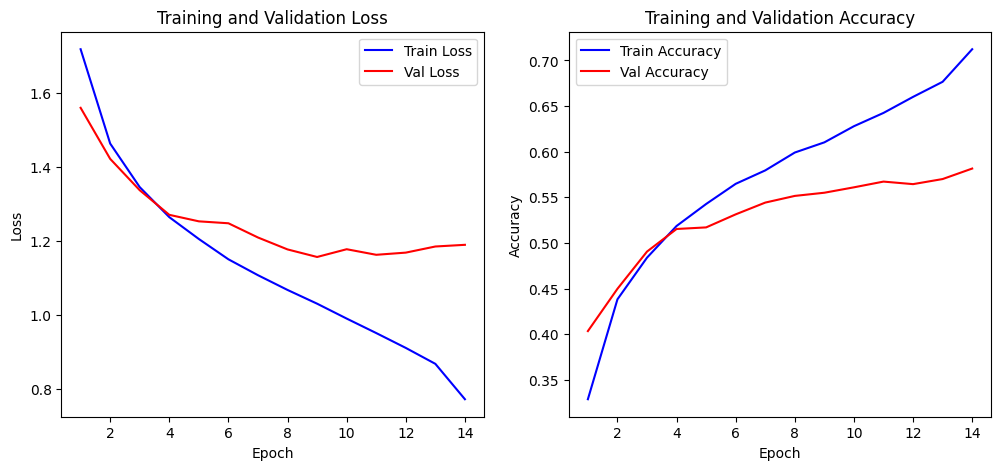

In [14]:
# Optional: Plot training and validation losses and accuracies
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.show()

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

Evaluating: 100%|██████████| 113/113 [00:09<00:00, 12.36it/s]


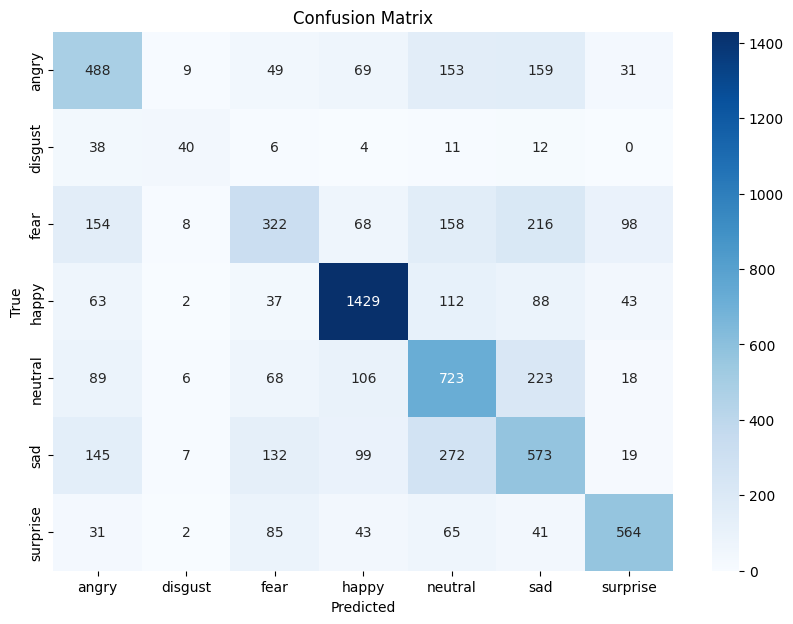

Classification Report:
              precision    recall  f1-score   support

       angry       0.48      0.51      0.50       958
     disgust       0.54      0.36      0.43       111
        fear       0.46      0.31      0.37      1024
       happy       0.79      0.81      0.80      1774
     neutral       0.48      0.59      0.53      1233
         sad       0.44      0.46      0.45      1247
    surprise       0.73      0.68      0.70       831

    accuracy                           0.58      7178
   macro avg       0.56      0.53      0.54      7178
weighted avg       0.58      0.58      0.57      7178



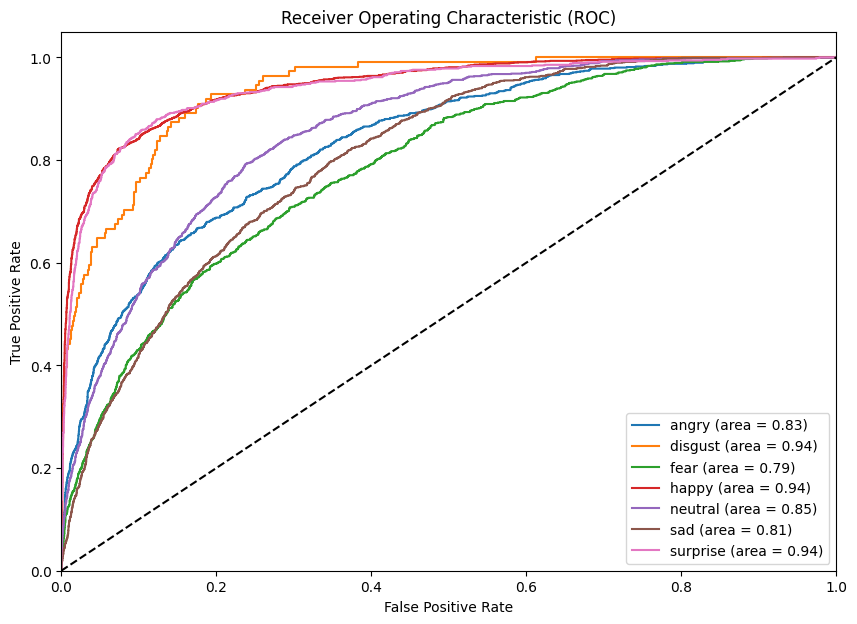

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Evaluate the model on test data
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    test_labels = []
    test_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return test_labels, test_preds, all_probs

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_probs, class_names):
    plt.figure(figsize=(10, 7))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true, y_probs[:, i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

def print_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Run evaluation
test_labels, test_preds, all_probs = evaluate_model(model, test_loader)

# Convert labels to numpy arrays
test_labels = np.array(test_labels)
test_preds = np.array(test_preds)
all_probs = np.array(all_probs)

# Access the underlying dataset to get class names
class_names = train_loader.dataset.dataset.classes

# Plot results
plot_confusion_matrix(test_labels, test_preds, class_names)
print_classification_report(test_labels, test_preds, class_names)
plot_roc_curve(test_labels, all_probs, class_names)


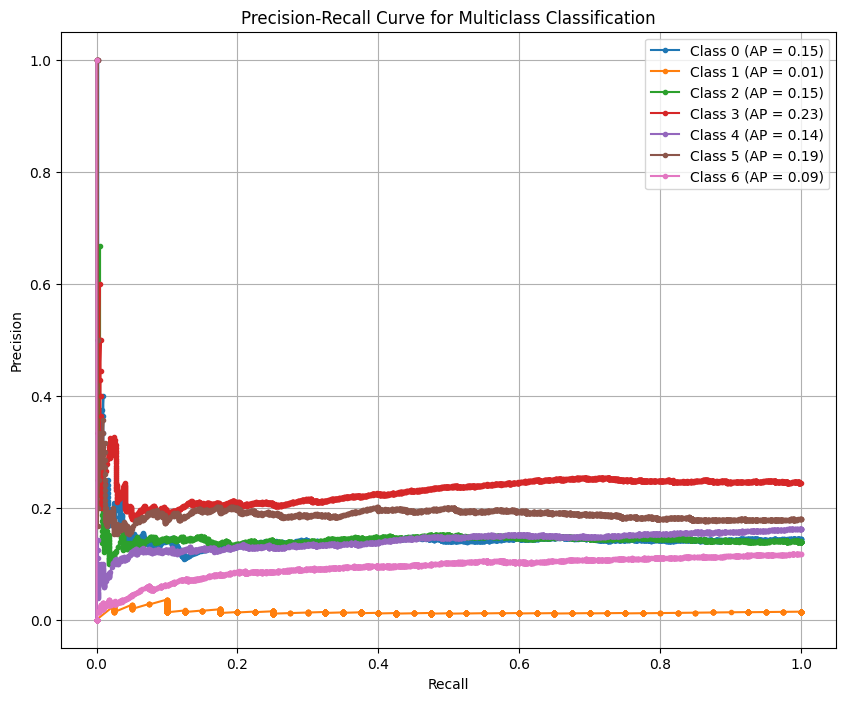

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Assuming you have a validation or test data loader
all_preds, all_labels = evaluate_model(model, val_loader)

# Binarize the labels for multiclass precision-recall
num_classes = all_preds.shape[1]
all_labels_bin = label_binarize(all_labels, classes=range(num_classes))

# Compute Precision-Recall curves and Average Precision scores for each class
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels_bin[:, i], all_preds[:, i])
    avg_precision[i] = average_precision_score(all_labels_bin[:, i], all_preds[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], marker='.', label=f'Class {i} (AP = {avg_precision[i]:.2f})')

plt.title('Precision-Recall Curve for Multiclass Classification')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
def accuracy_per_class(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for idx, accuracy in enumerate(class_accuracy):
        print(f'Accuracy for class {class_names[idx]}: {accuracy:.2f}')

# Calculate accuracy per class
accuracy_per_class(test_labels, test_preds, class_names)


Accuracy for class angry: 0.51
Accuracy for class disgust: 0.36
Accuracy for class fear: 0.31
Accuracy for class happy: 0.81
Accuracy for class neutral: 0.59
Accuracy for class sad: 0.46
Accuracy for class surprise: 0.68


In [18]:
def detailed_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Detailed Classification Report:")
    print(report)

# Print detailed classification report
detailed_classification_report(test_labels, test_preds, class_names)


Detailed Classification Report:
              precision    recall  f1-score   support

       angry       0.48      0.51      0.50       958
     disgust       0.54      0.36      0.43       111
        fear       0.46      0.31      0.37      1024
       happy       0.79      0.81      0.80      1774
     neutral       0.48      0.59      0.53      1233
         sad       0.44      0.46      0.45      1247
    surprise       0.73      0.68      0.70       831

    accuracy                           0.58      7178
   macro avg       0.56      0.53      0.54      7178
weighted avg       0.58      0.58      0.57      7178



In [19]:
def confusion_matrix_analysis(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix Analysis:")
    for i, row in enumerate(cm):
        for j, val in enumerate(row):
            if i != j and val > 0:
                print(f"Class {class_names[i]} is often confused with Class {class_names[j]}: {val} times")

# Analyze confusion matrix
confusion_matrix_analysis(test_labels, test_preds, class_names)


Confusion Matrix Analysis:
Class angry is often confused with Class disgust: 9 times
Class angry is often confused with Class fear: 49 times
Class angry is often confused with Class happy: 69 times
Class angry is often confused with Class neutral: 153 times
Class angry is often confused with Class sad: 159 times
Class angry is often confused with Class surprise: 31 times
Class disgust is often confused with Class angry: 38 times
Class disgust is often confused with Class fear: 6 times
Class disgust is often confused with Class happy: 4 times
Class disgust is often confused with Class neutral: 11 times
Class disgust is often confused with Class sad: 12 times
Class fear is often confused with Class angry: 154 times
Class fear is often confused with Class disgust: 8 times
Class fear is often confused with Class happy: 68 times
Class fear is often confused with Class neutral: 158 times
Class fear is often confused with Class sad: 216 times
Class fear is often confused with Class surprise: 

In [20]:
def confidence_analysis(y_true, y_probs, y_pred, class_names):
    incorrect_preds = y_true != y_pred
    incorrect_confidences = y_probs[incorrect_preds, y_pred[incorrect_preds]]
    print(f"Mean confidence in incorrect predictions: {incorrect_confidences.mean():.2f}")

# Analyze confidence
confidence_analysis(test_labels, all_probs, test_preds, class_names)


Mean confidence in incorrect predictions: 0.50


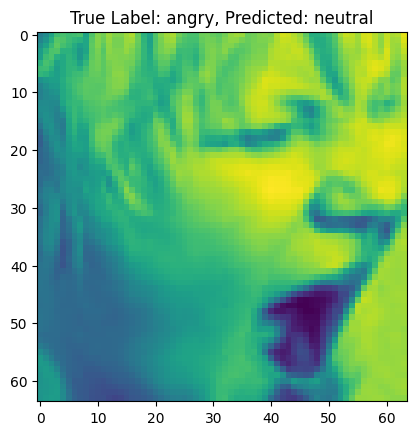

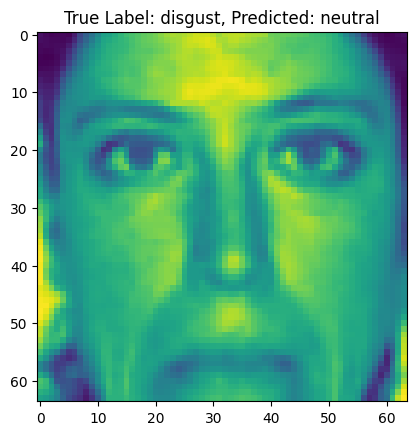

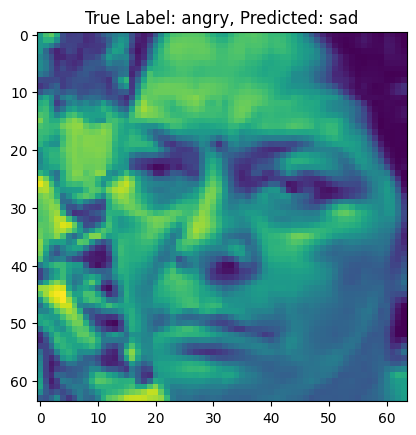

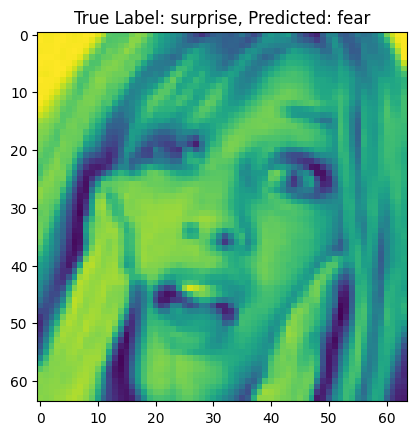

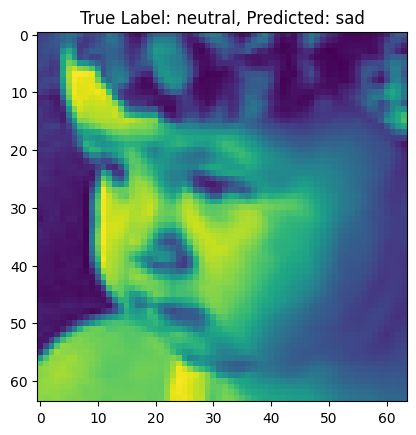

In [21]:
def plot_misclassified_examples(dataset, y_true, y_pred, num_examples=5):
    misclassified_idxs = np.where(y_true != y_pred)[0]
    for idx in np.random.choice(misclassified_idxs, num_examples, replace=False):
        img, label = dataset[idx]
        plt.imshow(img.permute(1, 2, 0))  # assuming img is in CHW format
        plt.title(f'True Label: {class_names[y_true[idx]]}, Predicted: {class_names[y_pred[idx]]}')
        plt.show()

# Plot some misclassified examples
plot_misclassified_examples(test_loader.dataset, test_labels, test_preds)


In [22]:
pip install torchcam


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 882.6 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [23]:
print(model)


TransferLearningModel(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

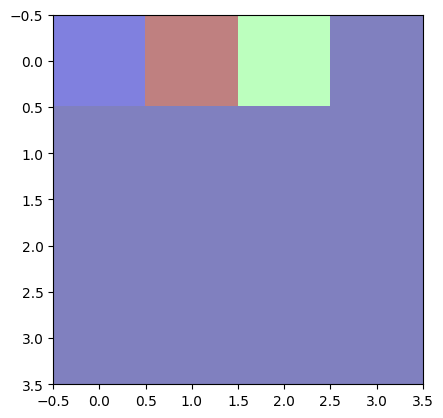

In [24]:
import torch
from torchcam.methods import GradCAM
import matplotlib.pyplot as plt

def apply_gradcam(model, input_image, target_class, target_layer):
    # Initialize GradCAM with the correct layer
    cam = GradCAM(model.base_model, target_layer=target_layer)
    
    # Forward pass to get model outputs
    model_output = model(input_image)
    
    # Apply GradCAM
    activation_maps = cam(class_idx=target_class, scores=model_output)
    
    # Since the result is a list, we get the first element
    activation_map = activation_maps[0]
    
    # Convert activation map to numpy and visualize
    activation_map = activation_map.squeeze().cpu().numpy()
    plt.imshow(activation_map, cmap='jet', alpha=0.5)
    plt.show()

# Example usage
model.eval()
input_image = test_dataset[0][0].unsqueeze(0).to(device)  # Adjust index as needed
target_class = 0  # Adjust the class as needed

# Apply Grad-CAM to the first block of layer3
apply_gradcam(model, input_image, target_class, target_layer='layer3.0.conv2')


In [25]:
from collections import defaultdict
import pandas as pd

def error_analysis_by_category(y_true, y_pred, class_names):
    errors_by_class = defaultdict(lambda: {'total': 0, 'incorrect': 0})

    for true_label, pred_label in zip(y_true, y_pred):
        errors_by_class[true_label]['total'] += 1
        if true_label != pred_label:
            errors_by_class[true_label]['incorrect'] += 1

    # Create DataFrame for easier analysis
    error_df = pd.DataFrame([
        {
            'Class': class_names[i],
            'Total': errors_by_class[i]['total'],
            'Incorrect': errors_by_class[i]['incorrect'],
            'Error Rate': errors_by_class[i]['incorrect'] / errors_by_class[i]['total']
        }
        for i in errors_by_class
    ])
    
    print(error_df)

# Example usage
error_analysis_by_category(test_labels, test_preds, class_names)


      Class  Total  Incorrect  Error Rate
0     angry    958        470    0.490605
1   disgust    111         71    0.639640
2      fear   1024        702    0.685547
3     happy   1774        345    0.194476
4   neutral   1233        510    0.413625
5       sad   1247        674    0.540497
6  surprise    831        267    0.321300


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AblatedCNN(nn.Module):
    def __init__(self):
        super(AblatedCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate the size of the input for the fully connected layer
        self.fc1_input_size = 64 * 16 * 16  # Adjusted based on the output size after conv layers and pooling
        self.fc1 = nn.Linear(self.fc1_input_size, 256)
        self.fc2 = nn.Linear(256, 7)  # Assuming 7 output classes

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))  # Apply conv1 and pool
        x = F.relu(self.pool(self.conv2(x)))  # Apply conv2 and pool

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))    # Apply first fully connected layer
        x = self.fc2(x)            # Apply second fully connected layer
        return x


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AblatedCNN().to(device)
print(model)

# Test with a batch of data
for inputs, labels in train_loader:
    print("Batch input shape:", inputs.shape)
    print("Batch label shape:", labels.shape)
    break


AblatedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)
Batch input shape: torch.Size([64, 1, 64, 64])
Batch label shape: torch.Size([64])


In [28]:
for inputs, labels in train_loader:
    print("Batch input shape:", inputs.shape)
    print("Batch label shape:", labels.shape)
    break


Batch input shape: torch.Size([64, 1, 64, 64])
Batch label shape: torch.Size([64])


In [29]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs
)


Epoch 1/50 - Validation: 100%|██████████| 45/45 [00:07<00:00,  6.37it/s]

Epoch 1/50 - Train Loss: 1.9493, Train Acc: 0.1193, Val Loss: 1.9488, Val Acc: 0.1268
Early stopping


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

# Define a simple CNN baseline model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32*64*64, 7)  # Number of classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 32*64*64)
        x = self.fc1(x)
        return x

# Train and evaluate the simple CNN
simple_cnn = SimpleCNN().to(device)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    simple_cnn, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs
)
test_accuracy, test_preds, test_labels = evaluate_model(simple_cnn, test_loader)

# Logistic Regression as a baseline
# Flatten the images and convert to numpy arrays for sklearn
X_train = np.array([img.flatten() for img, _ in train_dataset])
y_train = np.array([label for _, label in train_dataset])
X_test = np.array([img.flatten() for img, _ in test_dataset])
y_test = np.array([label for _, label in test_dataset])

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_baseline = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_baseline))


Epoch 1/50 - Validation: 100%|██████████| 45/45 [00:04<00:00, 10.36it/s]


Epoch 1/50 - Train Loss: 1.9479, Train Acc: 0.1576, Val Loss: 1.9485, Val Acc: 0.1592
Early stopping


ValueError: not enough values to unpack (expected 3, got 2)

In [31]:
def add_noise(image, noise_level=0.1):
    noise = torch.randn_like(image) * noise_level
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0, 1)  # Ensure values are within valid range

def test_robustness(model, test_loader, noise_level=0.1):
    model.eval()
    correct = 0
    total = 0

    for images, labels in test_loader:
        noisy_images = add_noise(images, noise_level)
        outputs = model(noisy_images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

    accuracy = correct / total
    print(f'Robustness Test Accuracy with noise level {noise_level}: {accuracy:.2f}')

# Example usage
test_robustness(model, test_loader, noise_level=0.1)


Robustness Test Accuracy with noise level 0.1: 0.18
